# STATS 765, Lab 05
## Lab 05 Overview
We discussed lasso and ridge regressions in the last lecture. In this lab, we use simulated data sets to fit these models and compare their performances to illustrate when one works better.

## Task 1: Generate simulated data sets
To understand how a statistical learning method works, it is important to simulate a mock-up data set where you know the underlying structure, so that you can use the data set to examine and validate the behavior of a model.

### Step 1.1: Generate the data sets
Run the following code chunk. As a warm-up, what do you expect the output would be when you run lm(Y~. data = dat_A)?

In [1]:
# load libraries
library(glmnet)
library(MASS)
library(tidyverse)

# set up parameters
set.seed(765) 
n <- 80  
p <- 80  
lambdas <- 2^ seq(6, -4, length = 100)  # lambda values.

# set up correlation matrix between Xs.
cor.mat <- matrix(0.7, nrow = p, ncol = p)
diag(cor.mat) <- 1
cor.mat[lower.tri(cor.mat)] <- t(cor.mat)[lower.tri(cor.mat)]

# dat_A
X1 <- mvrnorm(n, mu=rep(1, p), Sigma = cor.mat)
colnames(X1) <- paste0('X', str_pad(1:p, nchar(p), 'left', '0'))
n_betas <- 5
betas <- as.vector(scale(sample(1:n_betas))) * 10
related.ind <- sample(1:p, n_betas)
y1 <- as.numeric(betas %*% t(X1[,related.ind]) + rnorm(n))
dat_A <- cbind(data.frame(Y = y1), X1)

# dat_B
X2 <- mvrnorm(n, mu=rep(1, p), Sigma = cor.mat)
colnames(X2) <- paste0('X', str_pad(1:p, nchar(p), 'left', '0'))
all_betas <- sample(as.vector(scale(1:p))) * 0.1
y2 <- as.numeric(all_betas %*% t(X2) + rnorm(n))
dat_B <- cbind(data.frame(Y = y2), X2)

Loading required package: Matrix

Loaded glmnet 4.1-3

── Attaching packages ─────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ tidyr::expand() masks Matrix::expand()
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ tidyr::pack()   masks Matrix::pack()
✖ dplyr::select() masks MASS::select()
✖ tidyr::unpack() masks Matrix::unpack()



> I expect to see notable correlations between a handful of dat_A variables and y1, and lots of random noise.

### Step 1.2: Understand the code
Examine the code chunk from 1.1 above, what is the similarity and difference between the two data sets, dat_A and dat_B?

> Both datasets have X variables which are generated in the same way. Each observation of each variable in X is generated from a normal distribution with mean 1, such that all variables share the same covariance of 0.7.

> The $y$ values of dat_A are generated for each observation by randomly summing values from 5 $X_i$ variables, each value weighted by some $\beta_{X_i}$, with some additional random noise. Because one $\beta_{X_i}$ will be 0, this will result in a dataset dat_A with two positively correlated variables, one more so than the other, and two negatively correlated variables, again with varying scale of correlation. The correlations between $X_i$ and $y$ are thus sparse - only a few variables will be able to help us predict $y$.

> The $y$ values of dat_B are generated for each observation by summing the values from all $X_i$ variables, each weighted by some $\beta_{X_i}$, with some additional random noise. This should result in a dataset where all variables are correlated with $y$ in some small way, though the scale of that correlation is small compared to the added random noise.

### Step 1.3: Split into train and test
Split each one of the data sets into training (80%) and test (20%) sets. You should have train_A, test_A, train_B, and test_B by the end of this step.

In [2]:
train_ind <- sample(1:n, ceiling(0.8*n))
test_ind <- setdiff((1:n), train_ind)

train_A <- dat_A[train_ind,]
test_A <- dat_A[test_ind,]
train_B <- dat_B[train_ind,]
test_B <- dat_B[test_ind,]

## Task 2: Fit lasso regression
For each one of the data sets, do following:
1. fit a lasso model on the training set, with λ chosen by cross-validation.

In [3]:
# separate train X from y
train_A_X <- data.matrix(subset(train_A, select=-c(Y)))
train_A_y <- data.matrix(subset(train_A, select=c(Y)))
train_B_X <- data.matrix(subset(train_B, select=-c(Y)))
train_B_y <- data.matrix(subset(train_B, select=c(Y)))

# fit lasso type model on each training set, with 10-fold CV to select lambda
lassoA <- cv.glmnet(x=train_A_X, y=train_A_y, alpha=1, lambdas=lambdas, nfolds=10)
lassoB <- cv.glmnet(x=train_B_X, y=train_B_y, alpha=1, lambdas=lambdas, nfolds=10)

2. Calcuate the test MSPE, and the number of non-zero coefficient estimates from the optimal model.

In [4]:
# separate test X from y
test_A_X <- data.matrix(subset(test_A, select=-c(Y)))
test_A_y <- data.matrix(subset(test_A, select=c(Y)))
test_B_X <- data.matrix(subset(test_B, select=-c(Y)))
test_B_y <- data.matrix(subset(test_B, select=c(Y)))

In [5]:
# dat_A: predict and get test MSPE
pred_lassoA <- predict(lassoA, test_A_X)
mspe_lassoA <- mean( (test_A_y - pred_lassoA)^2 )
cat('MSPE of Lasso on A:', mspe_lassoA, fill=T)
cat('Number of non-zero coefs:', sum(coef(lassoA) != 0), fill=T)

MSPE of Lasso on A: 0.5722028
Number of non-zero coefs: 10


In [6]:
# dat_B: predict and get test MSPE
pred_lassoB <- predict(lassoB, test_B_X)
mspe_lassoB <- mean( (test_B_y - pred_lassoB)^2 )
cat('MSPE of Lasso on B:', mspe_lassoB, fill=T)
cat('Number of non-zero coefs:', sum(coef(lassoB) != 0), fill=T)

MSPE of Lasso on B: 1.371044
Number of non-zero coefs: 1


## Task 3: Fit ridge regression
For each one of the data sets, do following:

1. fit a ridge model on the training set, with λ chosen by cross-validation.

In [7]:
# fit ridge(alpha=0) type model on each training set, with 10-fold CV to select lambda
ridgeA <- cv.glmnet(x=train_A_X, y=train_A_y, alpha=0, lambdas=lambdas, nfolds=10)
ridgeB <- cv.glmnet(x=train_B_X, y=train_B_y, alpha=0, lambdas=lambdas, nfolds=10)

2. Calculate the test MSPE, and the number of non-zero coefficient estimates from the optimal model.

In [8]:
# dat_A: predict and get test MSPE
pred_ridgeA <- predict(ridgeA, test_A_X)
mspe_ridgeA <- mean( (test_A_y - pred_ridgeA)^2 )
cat('MSPE of Ridge on A:', mspe_ridgeA, fill=T)
cat('Number of non-zero coefs:', sum(coef(ridgeA) != 0), fill=T)

MSPE of Ridge on A: 122.7164
Number of non-zero coefs: 81


In [9]:
# dat_B: predict and get test MSPE
pred_ridgeB <- predict(ridgeB, test_B_X)
mspe_ridgeB <- mean( (test_B_y - pred_ridgeB)^2 )
cat('MSPE of Ridge on B:', mspe_ridgeB, fill=T)
cat('Number of non-zero coefs:', sum(coef(ridgeB) != 0), fill=T)

MSPE of Ridge on B: 1.371044
Number of non-zero coefs: 81


## Task 4: Compare and comment
Compare all the results from above (that is, two models for each of the two data sets), and comment on their performance.

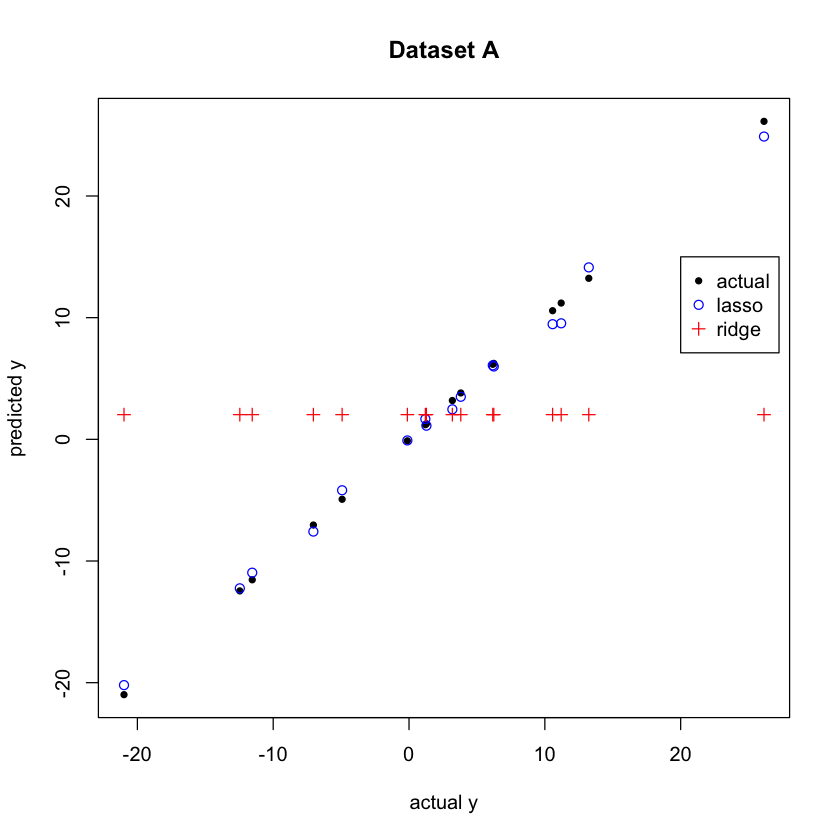

In [10]:
# Dataset A: lasso vs ridge
plot(x=test_A_y, y=test_A_y, col='black', pch=20, 
     xlab='actual y', ylab='predicted y', main='Dataset A')
points(test_A_y, pred_lassoA, col='blue', pch=1)
points(test_A_y, pred_ridgeA, col='red', pch=3)
legend(20, 15, legend=c('actual', 'lasso', 'ridge'), 
       pch=c(20, 1, 3), col=c('black', 'blue', 'red'))

> The lasso model performed very well for dataset A, because it was able to drop to zero the coefficients of the vast majority of variables which were not correlated with $y$. The lasso penalty was then able to select the sparse few variables that were correlated with $y$ and fit their coefficients well.

> The ridge model performed terribly on dataset A, because the ridge penalty did not enable coefficients to be dropped to zero. The model essentially set all weights as near to zero as it could, not being able to work out which variables were correlated with $y$ using the ridge penalty. This results in the same prediction for any $x$.

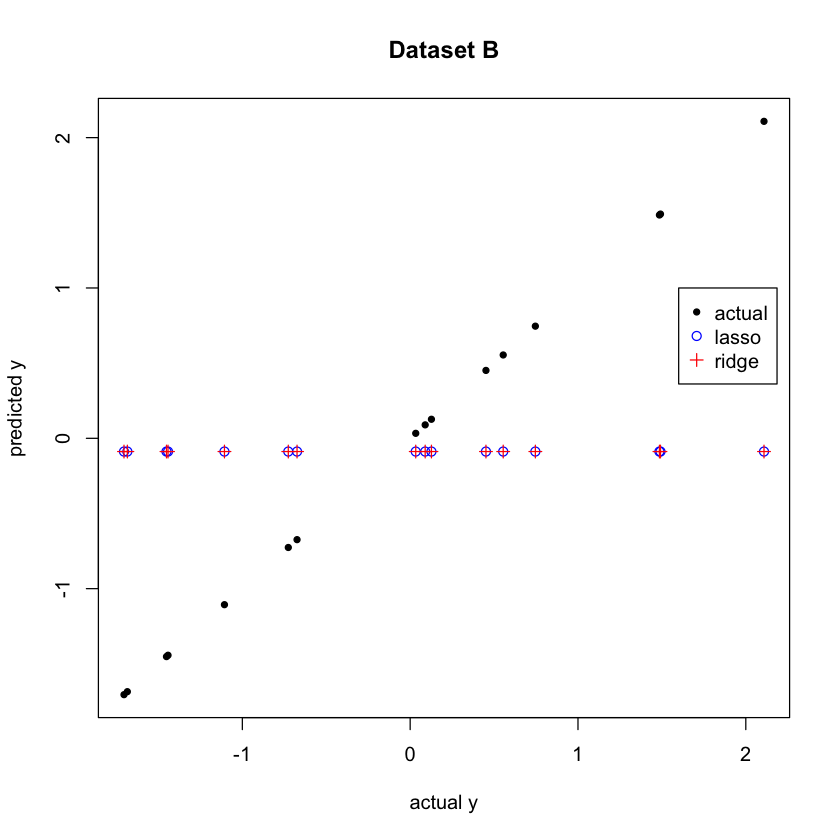

In [11]:
plot(x=test_B_y, y=test_B_y, col='black', pch=20, 
     xlab='actual y', ylab='predicted y', main='Dataset B')
points(test_B_y, pred_lassoB, col='blue', pch=1)
points(test_B_y, pred_ridgeB, col='red', pch=3)
legend(1.6, 1, legend=c('actual', 'lasso', 'ridge'), 
       pch=c(20, 1, 3), col=c('black', 'blue', 'red'))

> The lasso and ridge models performed equally poorly on dataset B. It seems that the dataset was simply too noisy for models using either penalty option to fit coefficients well, so all coefficients were dropped toward zero and the same prediction was made for any $X$.

### EOF